In [193]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg

import astropy.utils.exceptions
from astropy.io import fits
from matplotlib.patches import Rectangle
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder
from photutils import aperture_photometry, CircularAperture
from astropy import modeling

In [33]:
#My rewrite of IRAF method IMCOMBINE in Python-3
#Takes multiple images, lets work from text file instead of data
#Can do avg, med and sig clipping based on passed params
def imcombine(infile,average=False,median=False,sig=False,signum=3,expweight=False):
    #text file opener
    files=open(infile)
    #combined data(for avg) and an intialize boolean
    cmb_data=[]; init=False; cnt=0
    
    
    for i in files:
        cnt += 1 #increment counter
        hdul = fits.open(('Imaging_zf/'+str.strip(i)))
        data = hdul[0].data
        
        
        cmb_data.append(data)
       
    #determine row and col length of images
    y=len(cmb_data[0])
    x=len(cmb_data[0][0])
    cmb_data=np.asarray(cmb_data)
    
    temp=cmb_data
    #If sig filter is true
    out_data=[]
    if(sig):
        for i in range(cnt):
            avg=np.average(cmb_data[i])
            std=np.std(cmb_data[i])
            
            #If value > avg+-3sig set equal to image average.
            cmb_data[i][cmb_data[i] > avg+signum*std] = avg
            cmb_data[i][cmb_data[i] < avg-signum*std] = avg
    
            
    #If average is true, overrides median if both are true
    if(average):
        #weighting by sqrt(avg #photons in original image)
        if(expweight==True):
            avg=cmb_data[0]*np.sqrt(np.average(cmb_data[0]))
            for i in cmb_data[1:]:
                avg+=i*np.sqrt(np.average(i))
            avg=avg/cnt
            return(avg)
        else:
            avg=cmb_data[0]
            for i in cmb_data[1:]:
                avg+=i
            avg=avg/cnt
            return(avg)
    
    #If median is true
    #much much faster, one line vectored median from Matt Messersmith on S/O
    #https://stackoverflow.com/questions/52990299/faster-median-in-very-large-numpy-arrays
    if(median):
        median = np.zeros((1,y,x))
        median[0, :, :] = np.median(cmb_data,axis=0)

        return(median[0])        

In [9]:
#Rewrite of IRAF method colbias in Python 3
#Overscan looks like 0-52 and 2102-2199
#Chip suggests clip 60-2094 in x and 5 to 2044 in y

def colbias(data,plot=False):
    #Remove Overscan
    data_cp=[]
    bias_avg=[]
    for i in range(len(data)):
        #Calculate bias
        bias=np.average(data[i][2102:2199])
        bias_avg.append(bias)
    
        #remove bias and clip images
        if(i>5 and i<2044):
            data_cp.append(data[i][60:2094]-bias)
    #rewrite into np_array
    data_cb=np.asarray(data_cp)
    #Plot bias vals
    #print(bias_avg)
    if(plot):
        plt.figure()
        plt.plot(bias_avg)
        plt.show()
    #Return output array
    return data_cb

In [10]:
#Rewrite of IRAF method imstat in Python 3
def imstat(data,x1=0,x2=100000,y1=0,y2=100000):
    #If x2,y2 not set, set them to the max of the passed data
    if(x2==100000):
        x2=len(data[0])
        y2=len(data)
    #print(x1,x2,y1,y2)
    #clipped data, if applicable
    data_cp=[]
    #clip data to given range
    for i in range(len(data)):
        #clip in y
        if(i>y1 and i<y2):
                #clip in x
                data_cp.append(data[i][x1:x2])
    #Thank you numpy
    return([np.average(data_cp),np.std(data_cp),np.max(data_cp),np.min(data_cp)])

a043.fits , exptime= 3.0 [9221.227923790913, 2340.391412329042, 65535, 585]


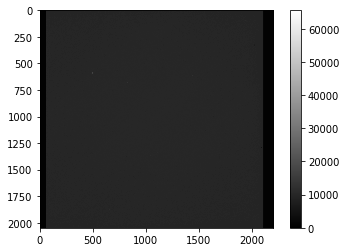

(2048, 2200)


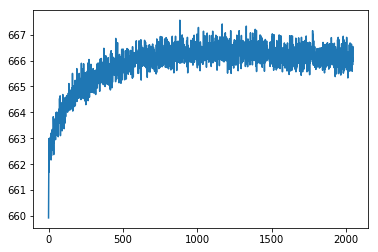

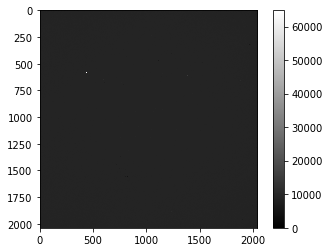

In [11]:
#Initial opening of all V-flats, as a comparison to colbias-flats

v_flats=open('Imaging/V_flats.txt')

for i in v_flats:
    hdul = fits.open(('Imaging/'+str.strip(i)))
    print(str.strip(i),', exptime=',hdul[0].header['EXPTIME'],imstat(hdul[0].data))
    plt.figure()
    plt.imshow(hdul[0].data,cmap='gray')
    plt.colorbar()
    plt.show()
    
    print(hdul[0].data.shape)
    
    cb=colbias(hdul[0].data,plot=True)
    #print(str.strip(i),imstat(cb),cb.shape)
    cnt=0
    for i,j in zip(cb,hdul[0].data[6:2043]):
        cnt+=1
        #if(np.abs(min(i)-min(j[60:2094]))>4000):
    
    plt.figure()
    plt.imshow(cb,cmap='gray')
    plt.colorbar()
    plt.show()
    
    break

b_flats=open('Imaging/B_flats.txt')

In [12]:
#Lets start by opening all images and calling colbias to remove zero-level and trim. 

imgs=open('Imaging/infiles.txt')

for i in imgs:
    hdul = fits.open(('Imaging/'+str.strip(i)))
    #data = hdul[0].data
    
    hdul[0].data=colbias(hdul[0].data)
    hdul.writeto(fileobj=('Imaging_zf/'+str.strip(i)+".zf"),overwrite=True)

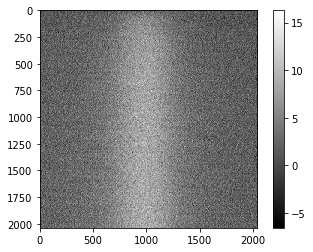

In [34]:
#Now lets make the master bias, average with sigma rejection
#And seeing that it has a pattern, subtract it from all images

m_bias=imcombine('Imaging_zf/biases.txt',average=True,sig=True)

plt.figure()
plt.imshow(m_bias,cmap='gray')
plt.colorbar()
plt.show()

infiles=open('Imaging_zf/infiles.txt')

for i in infiles:
    hdul = fits.open(('Imaging_zf/'+str.strip(i)))
    #data = hdul[0].data
    hdul[0].data=(hdul[0].data)-m_bias
    hdul.writeto(fileobj=('Imaging_zf_bf/'+str.strip(i)+".bf"),overwrite=True)

   Filename				Avg		St-Dev		Max		Min
a043.fits.zf.bf , exptime= 3.0 [9190.426763038931, 227.93672956769745, 64869.76180141074, -21.775908844275627]


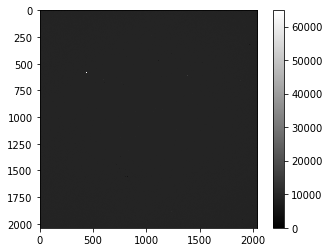

a044.fits.zf.bf , exptime= 6.0 [16308.441176017986, 329.74949105205087, 64872.007596310366, 14.015735214324494]


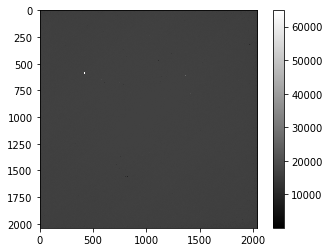

a045.fits.zf.bf , exptime= 12.0 [28050.184337840124, 478.76339174108574, 64871.20021703744, 18.737927292457925]


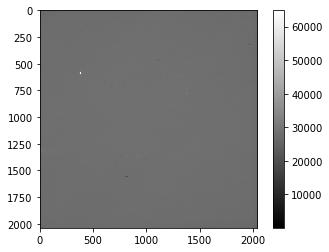

a046.fits.zf.bf , exptime= 12.0 [24059.373635190914, 443.84313487897646, 64870.12798217474, 23.232772653282723]


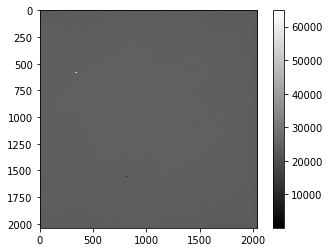

a047.fits.zf.bf , exptime= 20.0 [34701.146228573, 567.824622325082, 64866.19533369506, 32.68638090070533]


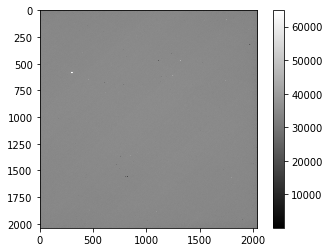

a048.fits.zf.bf , exptime= 20.0 [29652.36847939469, 530.551174819769, 64866.76507273797, 22.53391209983723]


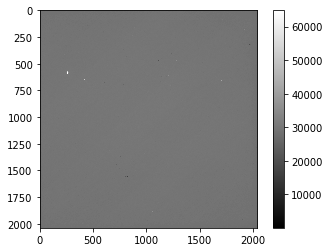

a049.fits.zf.bf , exptime= 20.0 [25738.239002197526, 505.8093756574197, 64865.06954312715, 22.531199131850215]


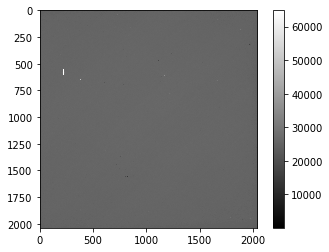


						Avg		St-Dev		Max			Min
Straight Average                  : [1.0000144870341197, 0.014393039821362688, 1.3541285541912471, 0.0009279122102113656]
Straight Median                   : [1.0000143392763563, 0.014531917027454584, 1.1256453893754828, 0.0009027748298752822]
Average w/ rejection              : [1.0000138166167825, 0.012482270117771612, 1.0436617459676099, 0.9476356210017689]
Average w/ rejection and weighting: [1.0000137557135669, 0.012448004409134024, 1.0443931726203237, 0.9480316750459139]


In [14]:
#Lets open the V-flats which the logfile indicates to be a043-a049 and imstat/get the exptime of each

v_flat=open('Imaging_zf_bf/V_flats.txt')
print('   Filename\t\t\t\tAvg\t\tSt-Dev\t\tMax\t\tMin')

for i in v_flat:
    hdul = fits.open(('Imaging_zf_bf/'+str.strip(i)))
    print(str.strip(i),', exptime=',hdul[0].header['EXPTIME'],imstat(hdul[0].data))
    plt.figure()
    plt.imshow(hdul[0].data,cmap='gray')
    plt.colorbar()
    plt.show()

#Ok, so definitely some saturated pixels, lets try a couple different Imcombines and scale to 1.0

print('\n\t\t\t\t\t\tAvg\t\tSt-Dev\t\tMax\t\t\tMin')

avg_Vflat=imcombine('Imaging_zf_bf/V_flats.txt',average=True,median=False,sig=False)
print('Straight Average                  :',imstat(avg_Vflat/np.average(avg_Vflat)))

med_Vflat=imcombine('Imaging_zf_bf/V_flats.txt',average=False,median=True,sig=False)
print('Straight Median                   :',imstat(med_Vflat/np.average(med_Vflat)))

avgsig_Vflat=imcombine('Imaging_zf_bf/V_flats.txt',average=True,median=False,sig=True)
print('Average w/ rejection              :',imstat(avgsig_Vflat/np.average(avgsig_Vflat)))

avgsigweight_Vflat=imcombine('Imaging_zf_bf/V_flats.txt',average=True,median=False,sig=True,expweight=True)
print('Average w/ rejection and weighting:',imstat(avgsigweight_Vflat/np.average(avgsigweight_Vflat)))

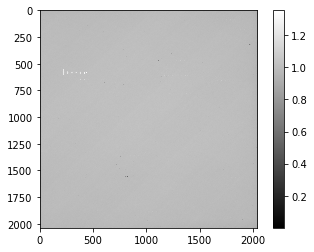

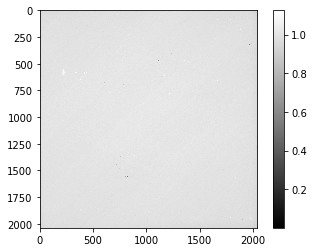

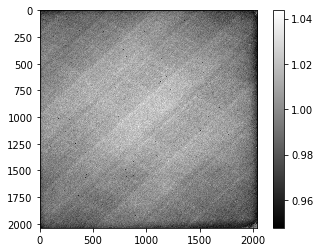

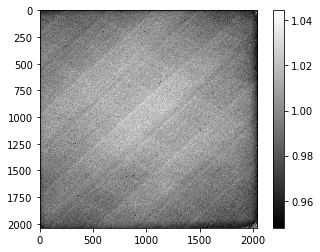

In [15]:
#We see that the rejection methods remove a lot of low pixels, which is not what I would expect. But do also
#result in the Max/Min being roughly 5% from unity which is what I would expect from examining flats manually

#To quantify results lets look at plots of these all:

plt.figure()
plt.imshow(avg_Vflat/np.average(avg_Vflat), cmap='gray')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(med_Vflat/np.average(med_Vflat), cmap='gray')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(avgsig_Vflat/np.average(avgsig_Vflat), cmap='gray')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(avgsigweight_Vflat/np.average(avgsigweight_Vflat), cmap='gray')
plt.colorbar()
plt.show()

#Lets use the sigma-rejected and exptime-weighted master-flat, should have highest signal

Average w/ rejection and weighting: [1.0000152639774766, 0.014589730772123584, 1.0475797424267899, 0.9460468381674785]
Average w/ rejection and weighting: [1.0000253542575175, 0.016247774023272217, 1.0762243851202042, 0.9006608159835271]


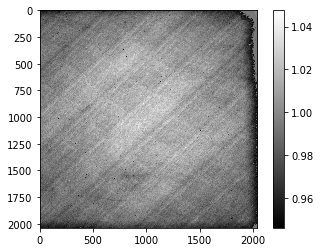

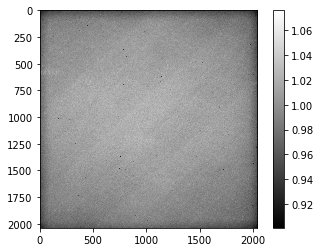

In [16]:
#Create B and R master flat

avgsigweight_Bflat=imcombine('Imaging_zf_bf/B_flats.txt',average=True,median=False,sig=True,expweight=True)
print('Average w/ rejection and weighting:',imstat(avgsigweight_Bflat/np.average(avgsigweight_Bflat)))

avgsigweight_Rflat=imcombine('Imaging_zf_bf/R_flats.txt',average=True,median=False,sig=True,expweight=True)
print('Average w/ rejection and weighting:',imstat(avgsigweight_Rflat/np.average(avgsigweight_Rflat)))

plt.figure()
plt.imshow(avgsigweight_Bflat/np.average(avgsigweight_Bflat), cmap='gray')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(avgsigweight_Rflat/np.average(avgsigweight_Rflat), cmap='gray')
plt.colorbar()
plt.show()

In [287]:
#perform masterflat division and re-save images
master_Vflat=avgsigweight_Vflat/np.average(avgsigweight_Vflat)
master_Bflat=avgsigweight_Bflat/np.average(avgsigweight_Bflat)
master_Rflat=avgsigweight_Rflat/np.average(avgsigweight_Rflat)

Vimgs=open('Imaging_zf_bf/Vfiles.txt')
Bimgs=open('Imaging_zf_bf/Bfiles.txt')
Rimgs=open('Imaging_zf_bf/Rfiles.txt')

for i in Vimgs:
    hdul = fits.open(('Imaging_zf_bf/'+str.strip(i)))
    #data = hdul[0].data
    hdul[0].data=(hdul[0].data)/master_Vflat
    hdul.writeto(fileobj=('Imaging_zf_bf_mf/'+str.strip(i)+".mf"),overwrite=True)
    
for i in Bimgs:
    hdul = fits.open(('Imaging_zf_bf/'+str.strip(i)))
    #data = hdul[0].data
    hdul[0].data=(hdul[0].data)/master_Bflat
    hdul.writeto(fileobj=('Imaging_zf_bf_mf/'+str.strip(i)+".mf"),overwrite=True)
    
for i in Rimgs:
    hdul = fits.open(('Imaging_zf_bf/'+str.strip(i)))
    #data = hdul[0].data
    hdul[0].data=(hdul[0].data)/master_Rflat
    hdul.writeto(fileobj=('Imaging_zf_bf_mf/'+str.strip(i)+".mf"),overwrite=True)

In [25]:
#Question 5
#Should be able to find gain as signal/(uncertainty^2)
#expecting value of 2 or 3
#Opening V-flatfielded-flats and calling imstat on central region

flats=open('Imaging_zf_bf_mf/V_flats.txt')

b1=fits.open('Imaging_zf/a093.fits.zf')
b2=fits.open('Imaging_zf/a094.fits.zf')

diff_bias=b1[0].data-b2[0].data

for i in flats:
    hdul=fits.open(('Imaging_zf_bf_mf/'+str.strip(i)))
    data=hdul[0].data
    
    gain=np.average(data[900:1100])/(np.std(data[900:1100])**2)
    print('Image      =',str.strip(i))
    print('Region     = [900:1100],[900:1100] ',)
    print('Gain       =',gain)
    print('Read Noise =',gain*np.std(diff_bias)/np.sqrt(2),'\n')

#Too small, suggests uncertainty is too large, why?



#Lets try opening two flats and biases instead

f1=fits.open(('Imaging_zf_bf_mf/a045.fits.zf.bf.mf'))
#print(f1[0].header['EXPTIME'])
f2=fits.open(('Imaging_zf_bf_mf/a046.fits.zf.bf.mf'))
#print(f2[0].header['EXPTIME'])

b1=fits.open('Imaging_zf/a093.fits.zf')
#print(b1[0].header['EXPTIME'])
b2=fits.open('Imaging_zf/a094.fits.zf')
#print(b2[0].header['EXPTIME'])

print(np.average(f1[0].data/12)+np.average(f2[0].data/12))
print(np.average(b1[0].data)+np.average(b2[0].data))

print((np.std(f1[0].data/12-f2[0].data/12))**2)
print((np.std(b1[0].data-b2[0].data))**2)

print((4343-7)/(1207-158))


Image      = a043.fits.zf.bf.mf
Region     = [900:1100],[900:1100] 
Gain       = 1.3337571111782174
Read Noise = 11.865057248143534 

Image      = a044.fits.zf.bf.mf
Region     = [900:1100],[900:1100] 
Gain       = 1.2341201145250913
Read Noise = 10.978689963265035 

Image      = a045.fits.zf.bf.mf
Region     = [900:1100],[900:1100] 
Gain       = 1.1151980554493655
Read Noise = 9.920763428384838 

Image      = a046.fits.zf.bf.mf
Region     = [900:1100],[900:1100] 
Gain       = 1.1466620018214855
Read Noise = 10.2006656098457 

Image      = a047.fits.zf.bf.mf
Region     = [900:1100],[900:1100] 
Gain       = 1.072443988207099
Read Noise = 9.540424721157741 

Image      = a048.fits.zf.bf.mf
Region     = [900:1100],[900:1100] 
Gain       = 1.0759178878795486
Read Noise = 9.571328412798799 

Image      = a049.fits.zf.bf.mf
Region     = [900:1100],[900:1100] 
Gain       = 1.0973082170744193
Read Noise = 9.761616043377636 

4342.393371503033
7.004399677623104
1207.7606075726146
158.2764044003

Max signal = 44881.698581811914 Average signal = 14.080055396830504 Exp Time = 2.0
Max signal = 65435.0834601232 Average signal = 28.12471260468994 Exp Time = 4.0
Max signal = 67880.43790791211 Average signal = 56.53378270736369 Exp Time = 8.0
Max signal = 67878.66879639789 Average signal = 111.21931341683496 Exp Time = 16.0
Max signal = 67876.61921598506 Average signal = 223.5531938988172 Exp Time = 32.0
Max signal = 67984.91377972721 Average signal = 444.63881561047594 Exp Time = 64.0
Max signal = 67994.67092674892 Average signal = 880.269504251137 Exp Time = 128.0


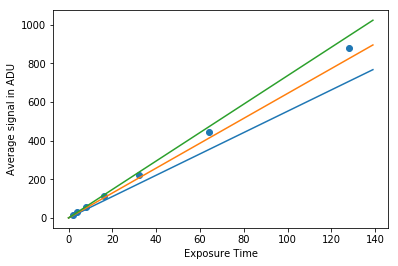

In [23]:
#Question 10, linearity test
#images 74-80, using science ready images

linear=open('Imaging_zf_bf_mf/linearity.txt')

times=[]
signal=[]

for i in linear:
    hdul=fits.open(('Imaging_zf_bf_mf/'+str.strip(i)))
    data=hdul[0].data
    
    times.append(hdul[0].header['EXPTIME'])
    signal.append(np.average(data))
    print('Max signal =',np.max(data),'Average signal =',np.average(data),'Exp Time =',hdul[0].header['EXPTIME'])
    
plt.scatter(times,signal)
plt.plot(6*np.linspace(0,128,140))
plt.plot(7*np.linspace(0,128,140))
plt.plot(8*np.linspace(0,128,140))

plt.xlabel('Exposure Time')
plt.ylabel('Average signal in ADU')
plt.show()    

In [111]:
#Function for calculating the signal-to-noise in a drawn aperture.
#cnts-in: counts in the aperture
#app_r  : aperturn radius
#bg_avg : average background level in area without clear stars
#bg_std : standard deviation from same background region
#gain   : gain value for CCD, determined in problem 5

def star_SN(cnts_in,app_r,bg_avg,bg_std,gain):
    n_pix=np.pi*app_r**2
    signal=cnts_in-bg_avg*n_pix
    noise=np.sqrt(signal/gain+((n_pix+1)*bg_std**2))
    
    return signal/noise
#Equation from https://www1.phys.vt.edu/~jhs/phys3154/snr20040108.pdf

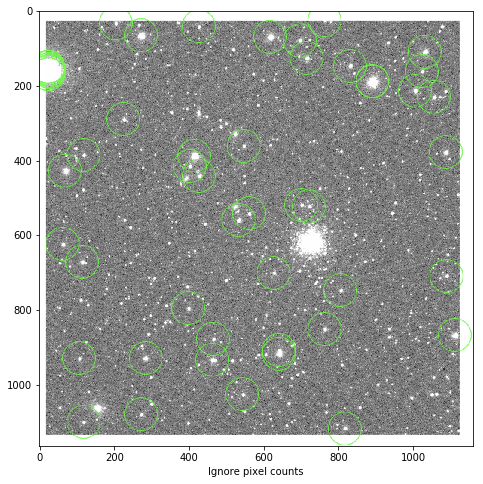

In [354]:
#Documentation for photutils, used heavily in this section
#https://photutils.readthedocs.io/en/stable/detection.html

#Set-up for questions 6-12

gain=1.14 #Correct with better value

#Opening Standard field (see Odewahn et al 1992)
data=fits.open('Imaging_zf_bf_mf/a185.fits.zf.bf.mf')[0].data
#Plotting ds9 scaled screenshot

plt.figure(figsize=(8,8))
img=mpimg.imread('a185.png')
imgplot = plt.imshow(img)
plt.xlabel('Ignore pixel counts')
plt.show()

#Take background avg and st-dev from empty area (visually inspected)
bg_avg,bg_std,bg_max,bg_min=imstat(data,x1=300,x2=350,y1=100,y2=150)

#Using DAOStarFinder from photutils, given a fwhm size and sigma-threshold above background
#this detects stars and returns their centroids and instrumental magntiudes
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*np.std(data))  
sources = daofind(data - np.median(data))
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  #make numpy array of source positions

#Create coord-file for ds9
for i in positions:
    print('circle('+str(i[0])+','+str(i[1])+','+"82.351754)")

#ds9 overlaid-coords show that we have like 6 "stars" in the top left, generally single stars otherwise.

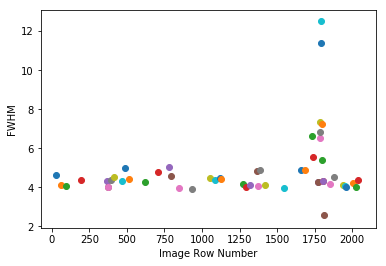

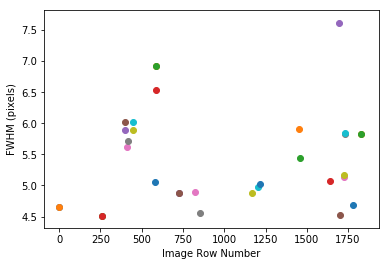

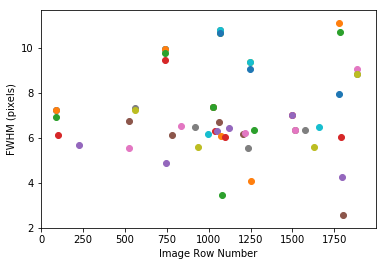

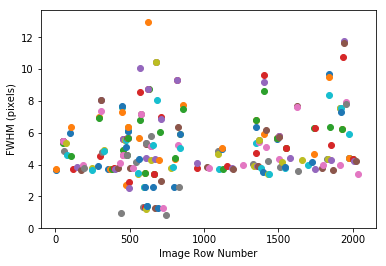

In [276]:
#Question 6
#measure psf of different stars at different airmass, different times, across single exp.
#make plots of psf variation w.r.t. time/airmass/chip location
#In uncomfotable situation of assuming psf to get centroids but then using centroids to get psf.

#Astropy Fitting info from:
#https://stackoverflow.com/questions/44480137/how-can-i-fit-a-gaussian-curve-in-python/44480190

def FWHM(row,w=10,plot=False):
    #determine half-max value and location of max_value
    HM=0.5*max(row)
    max_loc=np.argmax(row)
    width=w
    
    #Fit a gaussian to the data in the determined region
    x=np.arange(max_loc-width,max_loc+width,1)
    fitter = modeling.fitting.LevMarLSQFitter()
    #gaussian model from astropy, note passed amplitude and mean as priors
    model = modeling.models.Gaussian1D(amplitude=HM*2,mean=max_loc)  
    fitted_model = fitter(model, x, row[max_loc-width:max_loc+width])

    #Optional plot of fitted model vs data
    if(plot):
        plt.plot(row)
        plt.plot(x, fitted_model(x))
        plt.xlim(max_loc-width,max_loc+width)
        plt.show()
    
    #For a gaussian FWGM=2.355*sigma
    return(2.355*fitted_model.stddev.value)

#Looking across a single exp (airmass=1.24)
for i in positions:
    plt.scatter(i[1],FWHM(data[int(np.rint(i[1]))]))
plt.xlabel('Image Row Number')
plt.ylabel('FWHM')
plt.show()

def FWHM_plot(data):
    #Repeat process of plotting the FWHM for all stars DAOStarFinder finds in an image
    daofind = DAOStarFinder(fwhm=3.0, threshold=5.*np.std(data))  
    sources = daofind(data - np.median(data))
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

    for i in positions:
        plt.scatter(i[1],FWHM(data[int(np.rint(i[1]))]))
    plt.xlabel('Image Row Number')
    plt.ylabel('FWHM (pixels)')
    plt.show()
    
#Lets look at the FWHM for an image at higher airmass (a242) X=2.21 (also much later in night)
data=fits.open('Imaging_zf_bf_mf/a242.fits.zf.bf.mf')[0].data
FWHM_plot(data)

#Values seem to be much more random and have larger variance.
#Hard to seperate if this is due to a242 being taken at the end of the observing time or higher airmass.

#Lets take a look at two more images (a161) and (a166) which were taken at different X but close in time
data=fits.open('Imaging_zf_bf_mf/a161.fits.zf.bf.mf')[0].data
FWHM_plot(data)

data=fits.open('Imaging_zf_bf_mf/a166.fits.zf.bf.mf')[0].data
FWHM_plot(data)

#Here we see generally smaller FWHM in the higher airmass image. This is surprising, although it may
#be related to the vast number of stars in image a166. Overall from these four selected images
#it is hard to see any obvious trends in the FWHM.

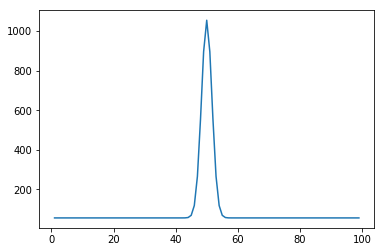

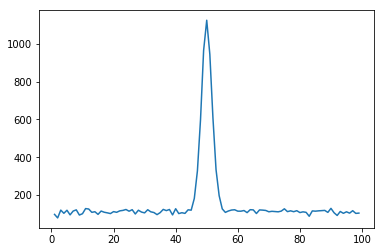

Std-dev of centroid = 0.20053130950166043


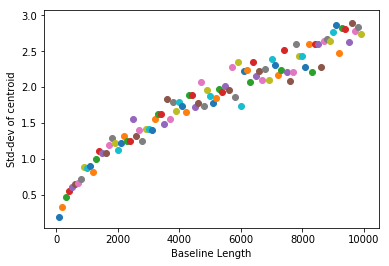

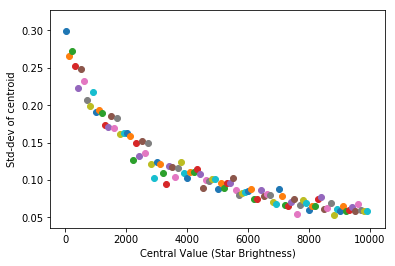

In [384]:
#Question 7
#I'm going to think about this with simulated data and a monte-carlo approach

#simple centroid calculation
def centroid(data_1d):
    wsum=0; cnt=0
    for i in data_1d:
        cnt+=1
        wsum+=(i*cnt)
    return(wsum/np.sum(data_1d))

#Monte-Carlo Method for calculating accuracy of centroid determination
#amp=amplitude of gaussian
#x1,x2 are range of x-values, baseline length
#runs is how many iterations before standard-deviation is calculated
#bg_avg and bg_std are information on image background used to add noise and better simulate data
def MC_centroids(amp,x1,x2,runs,bg_avg,bg_std,plot=False):
    
    #standard deviation from question 6 on FWHM, inverting result
    model = modeling.models.Gaussian1D(amplitude=amp,mean=(x1+x2)/2,stddev=4/2.355)
    x=np.arange(x1+1,x2,1)

    centroids=[]
    for i in range(runs):
        sample=model(x)+bg_avg #reset sample

        sample+=np.random.normal(loc=bg_avg,scale=bg_std,size=len(x)) #add gaussian noise from bg_std values

        centroids.append(centroid(sample))
    if(plot):
        plt.plot(x,model(x)+bg_avg)
        plt.show()
        plt.plot(x,sample)
        plt.show()
    
    return(np.std(centroids))

print('Std-dev of centroid =',MC_centroids(1000,0,100,10000,bg_avg,bg_std,plot=True))

#Lets take height of 1000 to be fiducial and look at how changing the baseline affects std of the centroid
for i in np.arange(100,10000,100):
    plt.scatter(i,MC_centroids(1000,0,i,100,bg_avg,bg_std))
plt.xlabel('Baseline Length')
plt.ylabel('Std-dev of centroid')
plt.show()
    
#Now lets instead take a width of 100 to be fiducial and look at how changing the gaussian amplitude
#(the stars peak value) affects std of the centroid

for i in range(10,10000,100):
    plt.scatter(i,MC_centroids(i,0,100,100,bg_avg,bg_std))
plt.xlabel('Central Value (Star Brightness)')
plt.ylabel('Std-dev of centroid')
plt.show()

#Clear trends that increasing baseline size decreases accuracy of measuring centroid
#and increasing star brightness and therefore star S/N (assuming noise ~constant) increases accuracy of measuring.

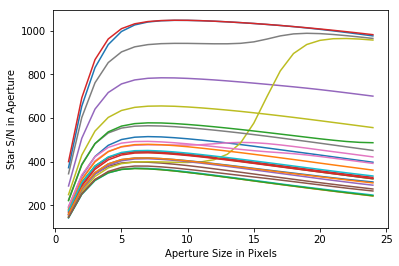

In [157]:
#Question 8
s_n=[] #array to hold all calculated S/N values

min_apsize=1; max_apsize=25

for i in range(min_apsize,max_apsize):
    s_n.append([])
    
    apertures = CircularAperture(positions, r=i) #draw apertures around center positions
    phot_table = aperture_photometry(data, apertures) #do photometry in those apertures
    
    for j in phot_table['aperture_sum']:
        s_n[i-1].append(star_SN(j,i,bg_avg,bg_std,gain))

#Re-cast as np array
s_n=np.asarray(s_n)

for i in range(len(s_n)):
    plt.plot(np.arange(min_apsize,max_apsize,1),s_n[:,i])
    
plt.xlabel("Aperture Size in Pixels")
plt.ylabel("Star S/N in Aperture")
plt.show()
    
#Generally the stars follow the expected trend from Howell, with two notable exceptions that I imagine come
#from the apertures of multiple stars bleeding together. Likely from the top left corner of overlaid-coords plot.

In [288]:
#Question 9
#take instrumental magnitudes for all standard stars
#images 083-088 and 183-186 and 189-190

#following the results of problem 6 and8, I'll use a 6-pixel aperture to capture the full signal and a fwhm of 4
#and I'll adjust the sigma threshold to match as many stars as I can from the std. fields

data=fits.open('Imaging_zf_bf_mf/a083.fits.zf.bf.mf')[0].data

daofind = DAOStarFinder(fwhm=4.0, threshold=5.*np.std(data))
sources = daofind(data - np.median(data))
for col in sources.colnames :  
    sources[col].info.format = '%.8g'  # for consistent table output
print(sources)
                  


 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag     
--- --------- --------- ---------- ... --- --------- --------- ------------
  1 1662.9093  9.214862 0.46168993 ...   0 17372.889 5.0775569    -1.764137
  2  1931.069 9.8939597 0.26489312 ...   0   65158.7 13.735385   -2.8446021
  3 1930.8948 11.621221 0.37607171 ...   0 65152.284 14.003606   -2.8655997
  4  293.6128 20.331276 0.46313728 ...   0 3836.0324 1.1327611  -0.13534586
  5 1916.3887 267.08917 0.44715304 ...   0 50294.567 14.262731   -2.8855067
  6 2011.8119 328.27947 0.45930563 ...   0 3562.5287 1.0204633 -0.021993497
  7 251.03652 388.42121 0.44585324 ...   0 4925.6619 1.4841586  -0.42870078
  8 423.97857  405.5504 0.31016044 ...   0 64674.051 20.642157   -3.2868877
  9 593.84919 423.07145  0.4676042 ...   0 29292.234  8.953005   -2.3799221
 10 796.87032 453.14686 0.46586524 ...   0 7284.2609 2.1923004  -0.85225017
...       ...       ...        ... ... ...       ...       ...          ...
 50  241.048

In [ ]:
#Question 11
#plot standard star instrument magniudes versus airmass
#for 083-088 (X=1.18), for 183-192 (X=1.24)
#plot difference between known magntiude and instrument magntiude verus airmass
#do least-squares to find and plot extinction coefficents in each filter

In [ ]:
#Question 12
#correct standard stars to zero airmasses
#plot difference between "real mag" and instrumental mag as a fn. of V-R and B-V color
#fit a linear relationship to get instrumental zero points and first color term for each band.